In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


## Optimizing in many dimensions


Our test landscape is a sum of Gaussian wells,
$$
\mathcal{L} = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

The gradient of this landscape is
$$
\nabla \mathcal{L} = \sum_{p=1}^P \frac{(\mathbf{x} - \boldsymbol{\mu}_{p})}{\sigma^2} \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

A few considerations:
+ Having a smooth landscape is important for optimization algorithms to work well. 
+ Optimization landscapes that are differentiable are necessary in order to compute gradient updates, and flat regions in the landscape pose challenges.

(-3.3, 3.3, -3.3, 3.3)

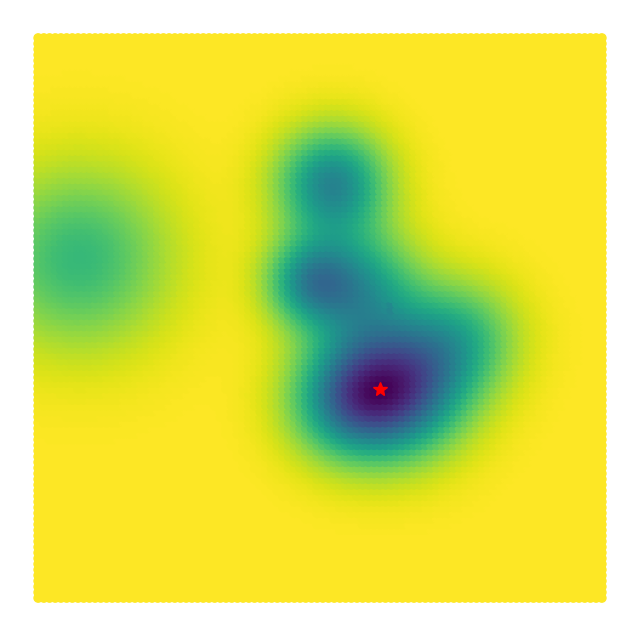

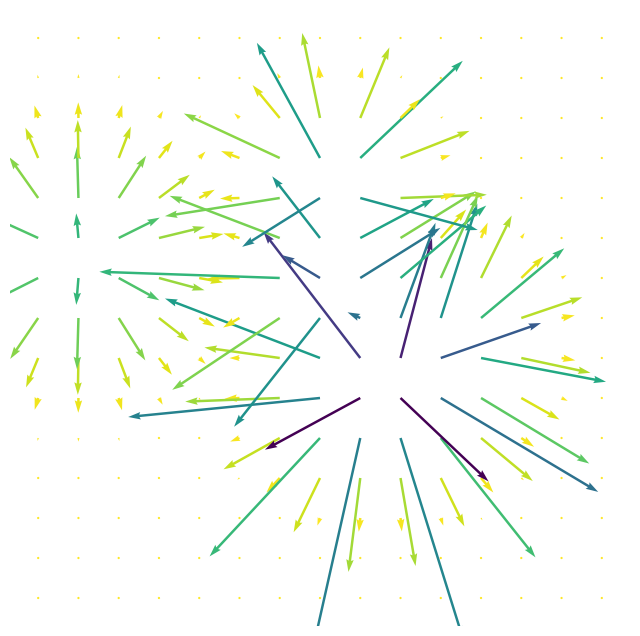

In [2]:

class RandomLossLandscape:
    """Creates a random two-dimensional loss landscape with multiple circular gaussian wells"""

    def __init__(self, d=2, n_wells=3, random_state=None):
        
        self.random_state = random_state
        np.random.seed(random_state)
        self.coeffs = np.random.random(n_wells)
        self.coeffs /= np.sum(self.coeffs)
        self.locs = np.random.randn(n_wells, d)
        self.widths = np.random.rand(n_wells)[None, :]

    def _gaussian_well(self, X, width=1):
        return -np.exp(-np.sum((X / width) ** 2, axis=1))

    def _grad_gaussian_well(self, X, width=1):
        return -2 * X / (width ** 2) * self._gaussian_well(X, width)[:, None, :]

    def loss(self, X):
        return np.einsum('...i,i->...', self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), self.coeffs)

    def grad(self, X):
        return np.einsum('...i,i->...', self._grad_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), self.coeffs)

    def __call__(self, X):
        return self.loss(X)


loss = RandomLossLandscape(random_state=0, n_wells=8)
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss(X) # same as loss.loss(X) because class is callable

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*r', markersize=10)
plt.axis('off')

plt.figure(figsize=(8, 8))
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)
plt.quiver(X[:, 0], X[:, 1], loss.grad(X)[:, 0], loss.grad(X)[:, 1], Z, scale=1e0)
# plt.streamplot(x, y, loss.grad(X)[:, 0].reshape(100, 100), loss.grad(X)[:, 1].reshape(100, 100), color=Z.reshape(100, 100))
plt.axis('off')

## Computing analytic gradients is hard

+ Computing analytic gradients is hard, and often impossible.
+ We can use finite differences to approximate the gradient, but this is computationally expensive: In $d$ dimensions, we need to evaluate the function $d$ times to compute the gradient. Impractical for high-dimensional problems.
+ Symbolic gradients are useful, but prone to errors
+ We use a gradcheck function to mitigate the risk of errors in our gradients.
+ (Later): Faster gradient estimation for more complex loss functions with automatic differentiation


In [7]:
def gradcheck(loss, x, eps=1e-9):
    """Checks the gradient of a function at a point"""
    x = np.array(x)
    grad = loss.grad(x)
    grad_num = np.zeros_like(grad)
    for i in range(x.size):
        x1 = x.copy()
        x2 = x.copy()
        x1.flat[i] += eps
        x2.flat[i] -= eps
        grad_num.flat[i] = (loss(x1) - loss(x2)) / (2 * eps)
    return grad, grad_num

grad, grad_num = gradcheck(loss, np.random.randn(2))

print(f"True gradient: {grad}, Approximate gradient: {grad_num}")

True gradient: [[-0.12941108 -0.01174901]], Approximate gradient: [[-0.12941109 -0.01174901]]


# Global maximization

+ Why bother using gradient descent when we can just check every point in our system's domain? That's literally how we generated the plot above.
+ For a continuous field, we need to pick some minimum length scale over which we don't expect the objective to change rapidly. For discrete optimization, we just try all combinations
+ Assume we need $N$ points to sample along any linear dimension. The number of queries to the objective function scales as $N^d$, where $d$ is the dimensionality



+ For the example we just used, we sampled $N = 100$ points along each dimension, resulting in $100^2 = 10^4$ function calls. 
+ Assuming $100$ points per axis, when $d = 3$ we have $10^6$ while for $d = 7$ it takes $10^14$, etc
+ Let's assume it takes $10$ $\mu s$ per evaluation. The 2D global search takes $0.1$ s, the 3D search takes $10$ s, the $d = 5$ search takes $1.15$ days, and the $d = 7$ search takes $32$ years

+ OpenAI DallE: an image generation model with $d = 12$ billion parameters. During training, this parameter space is searched in order to minimize a loss objective 
+ Local methods are probably a better idea

## Multivariate gradient descent

+ A first-order optimization method
+ If we assume that our current position is $\mathbf{x}$, then the gradient of the objective function at this point is $\nabla \mathcal{L}(\mathbf{x})$
+ The gradient descent update rule becomes $$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x})$$ where $\eta$ is a step size parameter we call the "learning rate" that determines the size of the step we take in the direction of the gradient

In [79]:
class MultivariateGradientDescent:
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, lr=0.1, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
        self.loss = loss
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        
        self.X = X
        if self.store_history:
            self.Xs = [self.X.copy()]
            self.losses = [self.loss(X)]
        for i in range(self.max_iter):

            self.X -= self.lr * self.loss.grad(self.X)

            if self.store_history:
                self.Xs.append(self.X.copy())
                self.losses.append(self.loss(self.X))

            # Stop early if loss is not decreasing any more for *any* batch elements
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break

    def plot_trajectory(self):
        plt.figure(figsize=(8, 8))
        plt.scatter(X[:, 0], X[:, 1], c=Z)
        plt.plot(self.X[:, 0], self.X[:, 1], 'r')
        plt.plot(self.X[:, 0], self.X[:, 1], '*r', markersize=10)
        plt.axis('off')


In [ ]:
# Initialize optimizer
optimizer = MultivariateGradientDescent(loss, lr=0.1, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

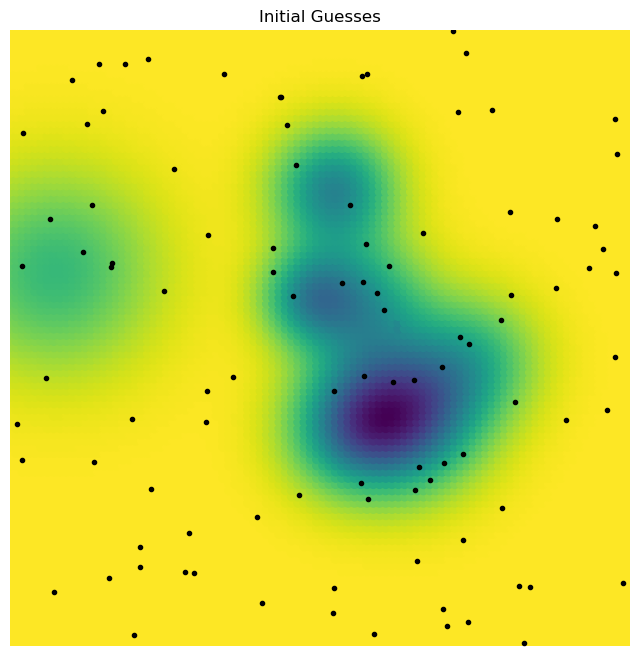

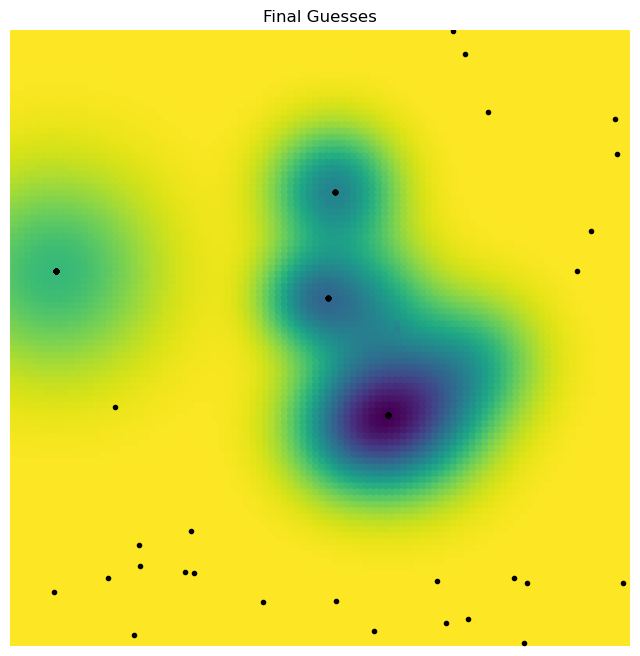

In [80]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*optimizer.X.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

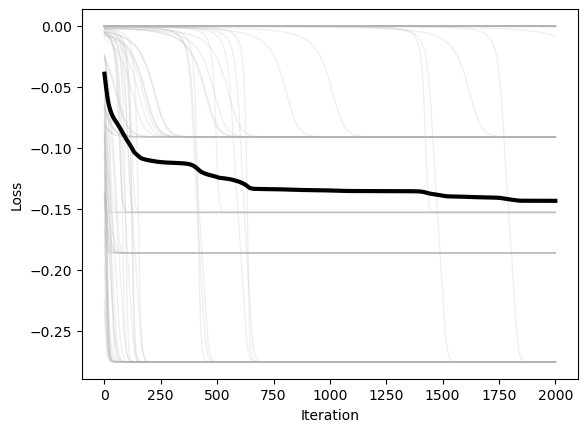

In [81]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


Text(0.5, 1.0, 'Final Guesses')

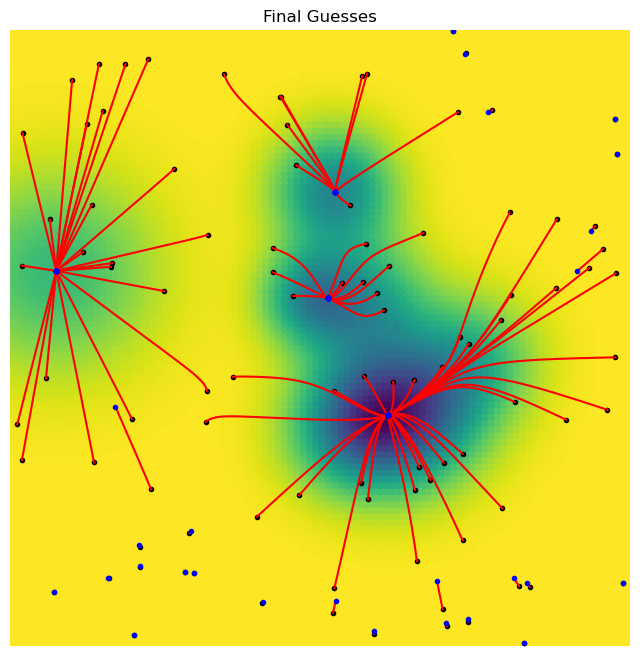

In [82]:
Xs = np.array(optimizer.Xs)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b');
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [83]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.b');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

## Momentum and stochasticity

We can think of gradent descent as the dynamics of a first-order overdamped system:

For a particle of mass $m$ in a potential $V(\mathbf{x})$, the forces acting on the particle are given by Newton's second law:
$$
\mathbf{F} = -\nabla \mathcal{U}(\mathbf{x})
$$

$$
\mathbf{a} = \frac{\mathbf{F}}{m}
$$

If we assume linear damping with a damping coefficient $\gamma$, then the dynamics of the particle are given by the kinematic equation:

$$
m \ddot{\mathbf{x}} = -\gamma \dot{\mathbf{x}} - \nabla \mathcal{U}(\mathbf{x})
$$
where $\mathbf{F}$ is the force, $\mathbf{a}$ is the acceleration.

If we assume $\gamma \gg m$, then the overdamped dynamics are given by the first-order equation of motion:
$$
\dot{\mathbf{x}} = -\frac{1}{\gamma}\nabla \mathcal{U}(\mathbf{x})
$$

In discrete time, the derivatives $\dot{\mathbf{x}}$ can be approximated using finite differences:
$$
\dot{\mathbf{x}} \approx \frac{\mathbf{x}_{t+1} - \mathbf{x}_t}{\Delta t}
$$

In discrete time, this equation corresponds to the update rule:
$$
\mathbf{x}_{t+1} = \mathbf{x}_t - \eta \nabla \mathcal{U}(\mathbf{x}_t)
$$
where $\eta = \Delta t / \gamma$ is the learning rate.

## Momentum

+ What if we want to take larger steps in the direction of the gradient?
+ In the overdamped limit, we can think of the gradient descent update rule as a first-order system with a damping coefficient $\gamma$. What if we are not in the underdamped limit?

The kinematic equation remains:
$$
m \ddot{\mathbf{x}} = -\gamma \dot{\mathbf{x}} - \nabla \mathcal{U}(\mathbf{x})
$$

In discrete time, the derivatives $\dot{\mathbf{x}}$ and $\ddot{\mathbf{x}}$ can be approximated using finite differences:
$$
\dot{\mathbf{x}} \approx \frac{\mathbf{x}_{t+1} - \mathbf{x}_t}{\Delta t}
$$
$$
\ddot{\mathbf{x}} \approx \frac{\mathbf{x}_{t+1} - 2\mathbf{x}_t + \mathbf{x}_{t-1}}{\Delta t^2}
$$



We can therefore add a momentum term to the update rule:
$$
\mathbf{x}_{t+1} = \mathbf{x}_t - \eta \nabla \mathcal{U}(\mathbf{x}_t) + \beta \left(\mathbf{x}_{t} - \mathbf{x}_{t-1}\right)
$$
where $\beta$ is a momentum parameter proprotional to mass that controls the size of the momentum term


In [85]:
class MultivariateGradientDescentMomentum:
    """A Multivariate Gradient Descent Optimizer with Momentum"""

    def __init__(self, loss, lr=0.1, beta=0.1, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
        self.loss = loss
        self.lr = lr
        self.beta = beta
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        
        self.X = X
        self.v = 0
        if self.store_history:
            self.Xs = [self.X.copy()]
            self.losses = [self.loss(X)]
        for i in range(self.max_iter):

            self.v = self.beta * self.v + self.lr * self.loss.grad(self.X)
            self.X -= self.v

            if self.store_history:
                self.Xs.append(self.X.copy())
                self.losses.append(self.loss(self.X))

            # Stop early if loss is not decreasing any more for *any* batch elements
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break

            

In [86]:
# Initialize optimizer
optimizer = MultivariateGradientDescentMomentum(loss, lr=0.1, beta=0.9, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

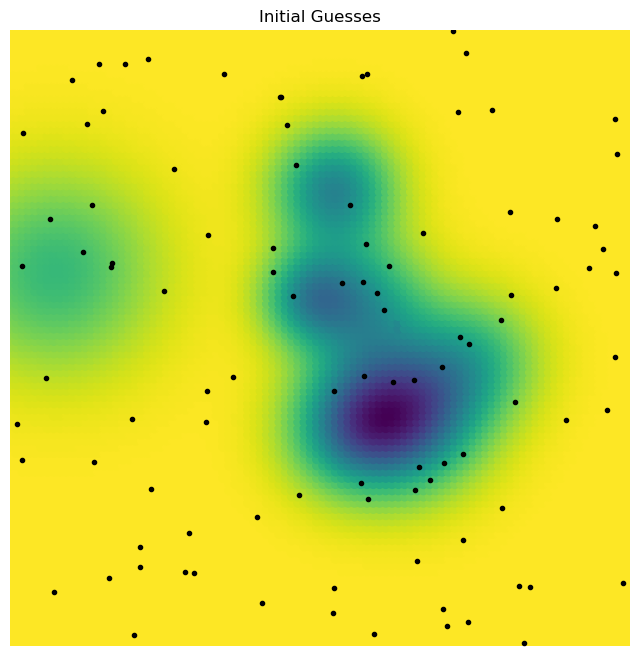

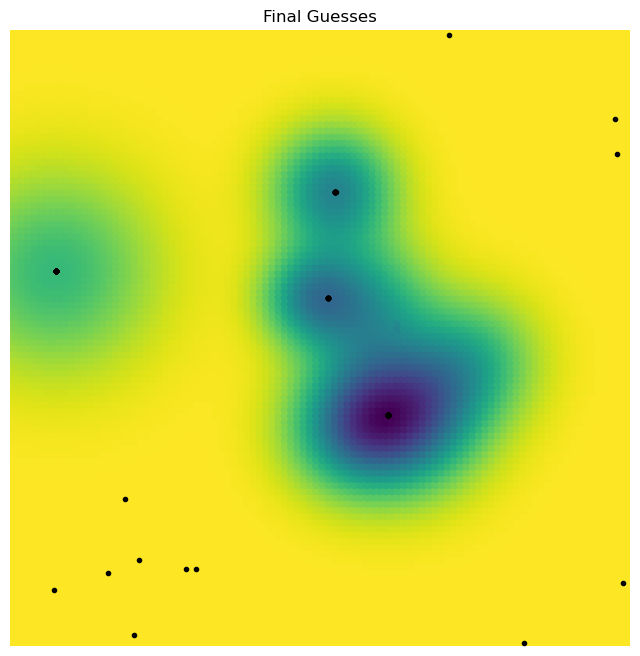

In [87]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*optimizer.X.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

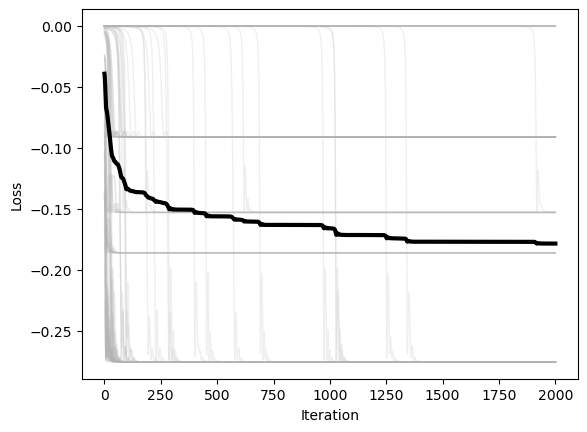

In [89]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


Text(0.5, 1.0, 'Final Guesses')

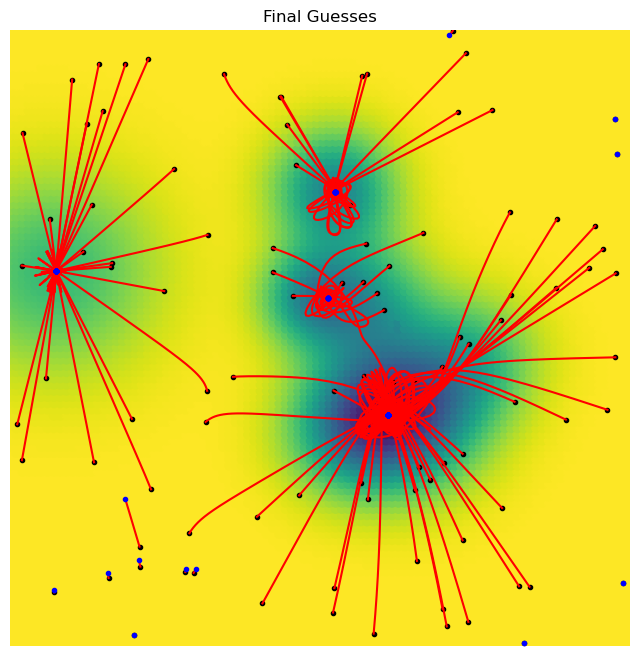

In [88]:
Xs = np.array(optimizer.Xs)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b');
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [90]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.b');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

## Hyperparameter tuning: What is the correct learning rate? Momentum?

+ Hyperparameter tuning is a big deal in machine learning, we will revisit this topic later in the course
+ For now, we will use intution to see how the learning rate and momentum affect the dynamics of the system

In [ ]:
class MultivariateNewtonsMethod:

    def __init__(self, loss, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
        self.loss = loss
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        self.X = X
        if self.store_history:
            self.Xs = [self.X]
            self.losses = [self.loss(X)]
        for i in range(self.max_iter):
            self.X -= np.linalg.inv(self.loss.hessian(self.X)) @ self.loss.grad(self.X)
            if self.store_history:
                self.Xs.append(self.X)
                self.losses.append(self.loss(self.X))
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break


## What about calculations with intermediate variables?

Forward pass

Backwards pass

## Finite difference derivatives

+ Symbolic derivatives much more practical
+ Computing them by hand is usually possible, but tedious

## Any tricks to do it faster?

+ Computational tricks for fast multivariate chain rule: Backpropagation, automatic differentiation
+ Most complex functions are compositions of matrix-vector products and unary functions like $\sin$, $\tanh$, etc
+ + Basic idea: the multivariate chain rule can be written as a graph, traversing this graph cna be optimized to reduce calls to nodes by caching intermediate results on the forward pass, etc
+ + We'll look at tools implementing these ideas behind the scenes in the next lab, but we won't go over the mathematics until the deep learning section of the course.


In [ ]:
class MultivariateNewton:
    def __init__(self, x, y, z, x0, y0, z0, alpha, beta, gamma, delta, epsilon):
        self.x = x
        self.y = y
        self.z = z
        self.x0 = x0
        self.y0 = y0
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon

    def f(self, x, y, z):
        return self.x * x + self.y * y + self.z * z

    def gradient(self, x, y, z):
        return np.array([self.x, self.y, self.z])

    def hessian(self, x, y, z):
        return np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    def newton_method(self):
        x = self.x0
        y = self.y0
        z = self.z0
        x_list = [x]
        y_list = [y]
        z_list = [z]
        for i in range(100):
            grad = self.gradient(x, y, z)
            hess = self.hessian(x, y, z)
            inv_hess = np.linalg.inv(hess)
            x = x - self.beta * np.dot(inv_hess, grad)[0]
            y = y - self.beta * np.dot(inv_hess, grad)[1]
            z = z - self.beta * np.dot(inv_hess, grad)[2]
            x_list.append(x)
            y_list.append(y)
            z_list.append(z)
        return x_list, y_list, z_list

        

# Convex Optimization

+ The cost function, fitness, or empirical risk is usually well-defined
+ + Error of a neural network on training data
+ + The fitness of a genotype
+ + The stability of a folded protein configuration
+ + Whether a given configuration is a true ground state or metastable

<br>

+ If we can query every point in input space, we can guarantee that we've found a global minimum
+ If the function is convex, we can step towards minima in a principled way

+ Non-convex, we either have to perform many queries, or have external information that we can use to refine our search. Non-convex optimization over binary variables is NP-hard
+ + That means it's in the same difficulty class as [Donkey Kong Country](https://arxiv.org/abs/1203.1895)


Text(0.5, 1.0, 'A non-convex optimization problem')

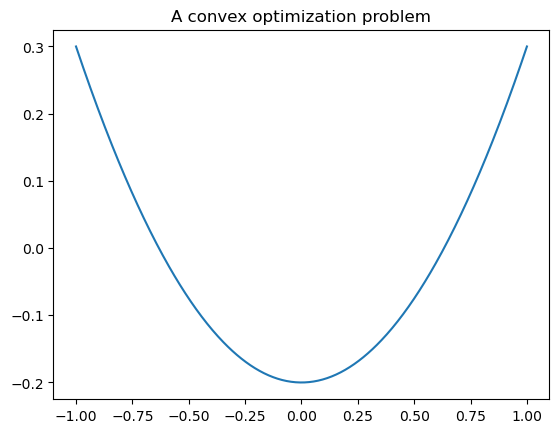

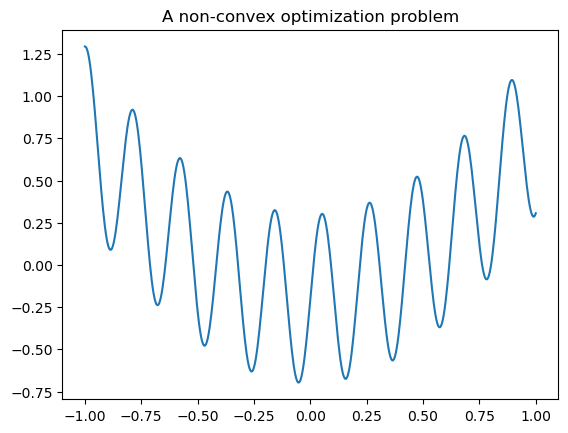

In [34]:
xx = np.linspace(-1, 1, 500)

f_con = lambda x: 0.5 * x**2 - 0.2
f_noncon = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2

plt.figure()
plt.plot(xx, f_con(xx))
plt.title('A convex optimization problem')

plt.figure()
plt.plot(xx, f_noncon(xx))
plt.title('A non-convex optimization problem')



We've already seen an example: in the Conjugate Gradient Method, we took steps towards a fixed point that represented the least-squares solution to the unconstrained linear problem


# One dimensional optimization: fixed point methods and rootfinding

+ I'm given some function $f(x)$, and I want to calculate the global minimum (convex) or the nearest local minimum to a start point (for nonconvex)
+ We use our standard approach of finding the nearest point at which $f' = 0$, reducing the calculation to rootfinding



# Gradient descent

+ A first-order method
+ a basic hill-climbing algorithm
+ Requires an estimate of the derivative of the loss function. Minimizing the loss is equivalent to finding the root of its derivative

Starting from an arbitrary point on the landscape, take steps along the direction of steepest descent

$$
x \leftarrow x - \eta \dfrac{df}{dx}
$$

The learning rate is a "hyperparameter" that we choose based on problem knowledge. Too large, and we can get stuck in oscillating solutions around the optima. Too small, and the system takes a long time to converge.

Optimal value: -0.19999999995313303


Text(0, 0.5, 'x')

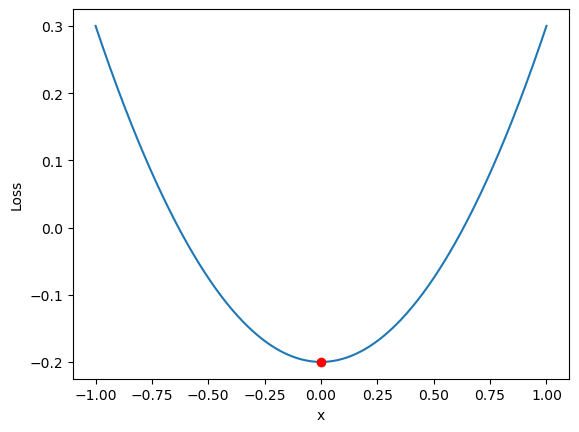

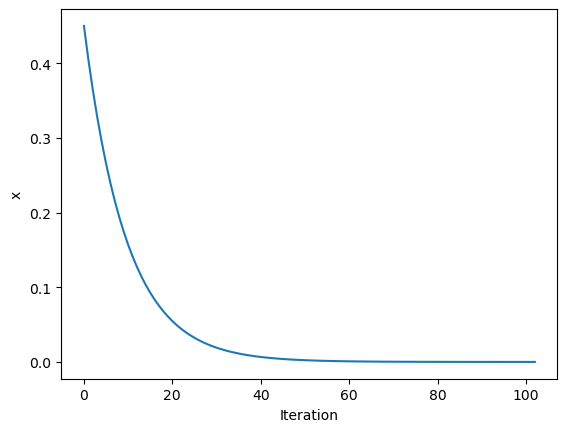

In [90]:
class GradientDescentOptimizer:

    def __init__(self, learning_rate=0.1, max_iter=1000, tolerance=1e-6, store_history=False):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.store_history = store_history
        if self.store_history:
            self.history = list()

    def optimize(self, df, x0):
        x = x0
        for i in range(self.max_iter):
            x_new = x - self.learning_rate * df(x)
            if np.linalg.norm(x_new - x) < self.tolerance:
                break
            x = x_new

            if self.store_history:
                self.history.append(x_new)

        return x

loss = lambda x: 0.5 * x**2 - 0.2
loss_grad = lambda x: x

optimizer = GradientDescentOptimizer(store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.5)

plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

### Modifying gradient descent for non-convex functions

We can add *momentum* to the optimizer, so that it keeps a memory of past timesteps and bearings

$$
v \leftarrow \eta \dfrac{df}{dx} + \alpha\, v
$$

$$
x \leftarrow x - v
$$

Text(0, 0.5, 'x')

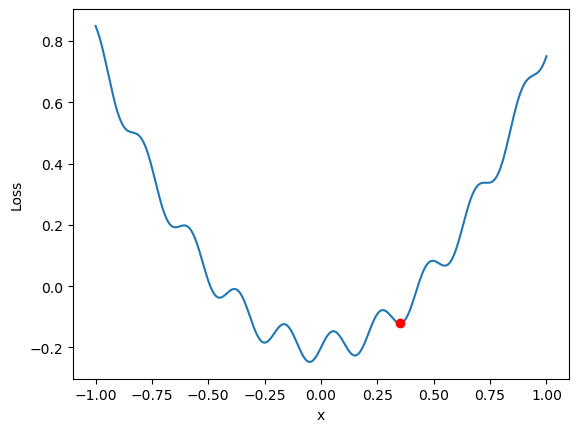

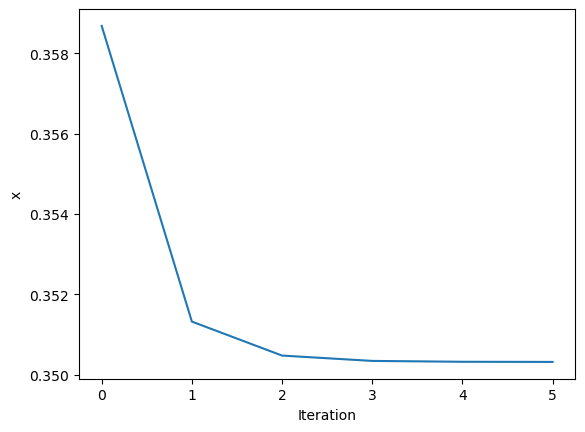

In [109]:
loss = lambda x: x**2 + 0.05 * np.sin(30 * x) - 0.2
loss_grad = lambda x: 2 * x + 0.05 * 30 * np.cos(30 * x)

## Solve optimization
optimizer = GradientDescentOptimizer(learning_rate=0.02, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.4)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')


Text(0, 0.5, 'x')

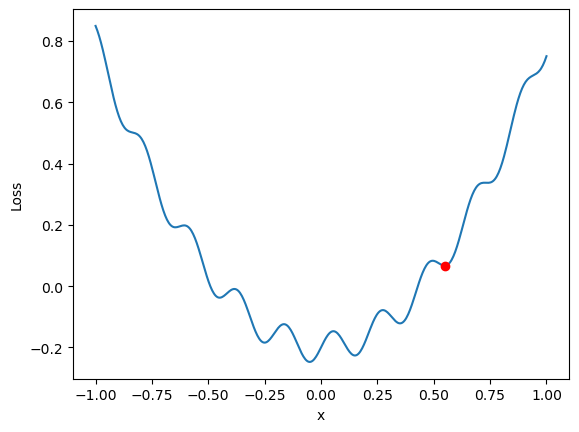

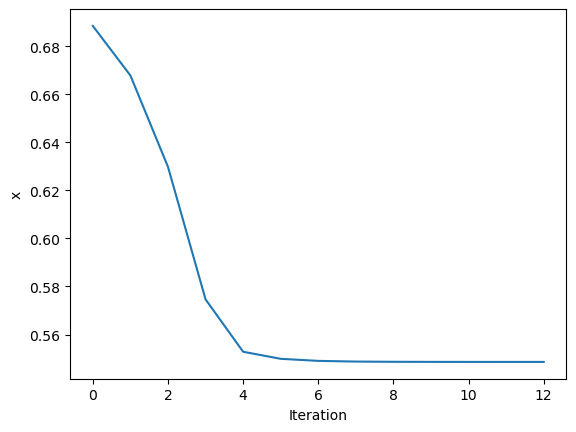

In [117]:
## Solve optimization
optimizer = GradientDescentOptimizer(learning_rate=0.02, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.7)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

Text(0, 0.5, 'x')

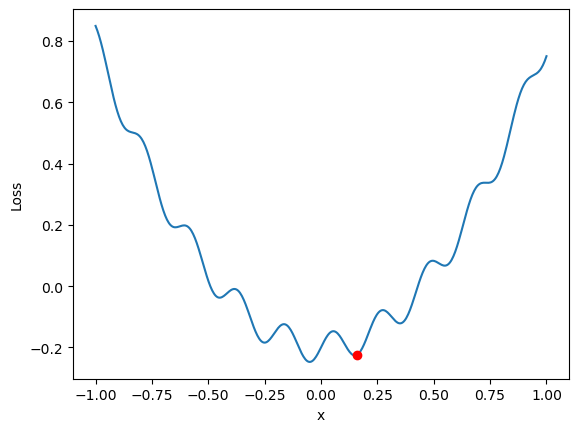

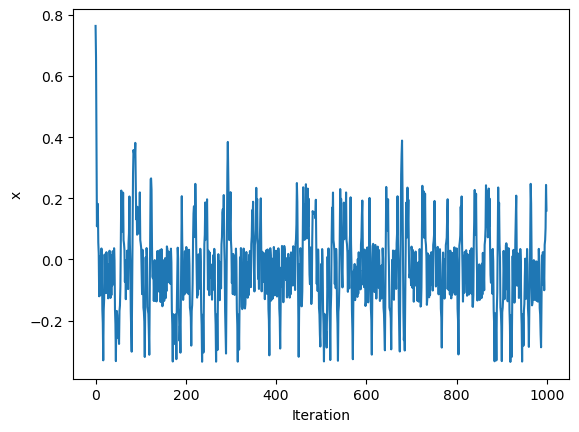

In [128]:
class GradientDescentMomentumOptimizer:
    
        def __init__(self, learning_rate=0.1, momentum=0.9, max_iter=1000, tolerance=1e-6, store_history=False):
            self.learning_rate = learning_rate
            self.momentum = momentum
            self.max_iter = max_iter
            self.tolerance = tolerance
            self.store_history = store_history
            if self.store_history:
                self.history = list()
    
        def optimize(self, df, x0):
            x = x0
            v = 0
            for i in range(self.max_iter):
                v = self.momentum * v + self.learning_rate * df(x)
                x_new = x - v
                if np.linalg.norm(x_new - x) < self.tolerance:
                    break
                x = x_new
    
                if self.store_history:
                    self.history.append(x_new)
    
            return x

## Solve optimization
optimizer = GradientDescentMomentumOptimizer(learning_rate=0.1, momentum=0.3, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.9)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

## Second-order methods and Newton's method

Can we improve convergence using information about the local landscape geometry?

### Newton's method

Suppose that our initial guess is $x_k$. We perform a second-order Taylor expansion around the guess,
$$
{\displaystyle f(x_{k}+ h)\approx f(x_{k})+f'(x_{k})h +{\frac {1}{2}}f''(x_{k})h^{2}.}
$$
We want to minimize this approximated local function in $h$,
$$
{\displaystyle \displaystyle 0={\frac {\rm {d}}{{\rm {d}} h}}\left(f(x_{k})+f'(x_{k})h+{\frac {1}{2}}f''(x_{k})h^{2}\right)=f'(x_{k})+f''(x_{k})h,}
$$
Solving this equation, we arrive at 
$$
h^* = -{\frac {f'(x_{k})}{f''(x_{k})}},
$$

Having optimized the approximant, we now update the position of $x$,
$$
x_{k+1} = x_{k} + h^* = x_{k} - {\frac {f'(x_{k})}{f''(x_{k})}}.
$$

Basically, in a single timestep Newton's method we approximate the function locally as a parabola, and we then jump to the optimum of that parabolic approximant. Newton's method therefore consists of optimizing a global function by optimizing a series of local approximants.

<br><br>

### What if we don't know the derivatives of $f(x)$?

+ This is sometimes called the "secant" method
+ In many types of problems, we are best served by having a loss function with a differentiable form
+ As a fallback, we can use finite difference operators to approximate $f'$ and $f''$

$$
f'(x) \approx \dfrac{f(x + \Delta x / 2) - f(x - \Delta x / 2)}{\Delta x}
$$
$$
f''(x) \approx \dfrac{f(x + \Delta x) - 2 f(x) + f(x - \Delta x)}{\Delta x^2}
$$
where $\Delta x / x \ll 1$

Here we have used central finite differences, but we could also use forward finite differences
$$
f'(x) \approx \dfrac{f(x + \Delta x) - f(x)}{\Delta x}
$$
$$
f''(x) \approx \dfrac{f(x + 2 \Delta x) - 2 f(x + \Delta x) + f(x)}{\Delta x^2}
$$
Or, analogously, backwards finite differences.

There also exist [higher-order finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference), as well as multivariate generalizations. Notice how the coefficients of the first and second derivatives are Pascal's triangle.

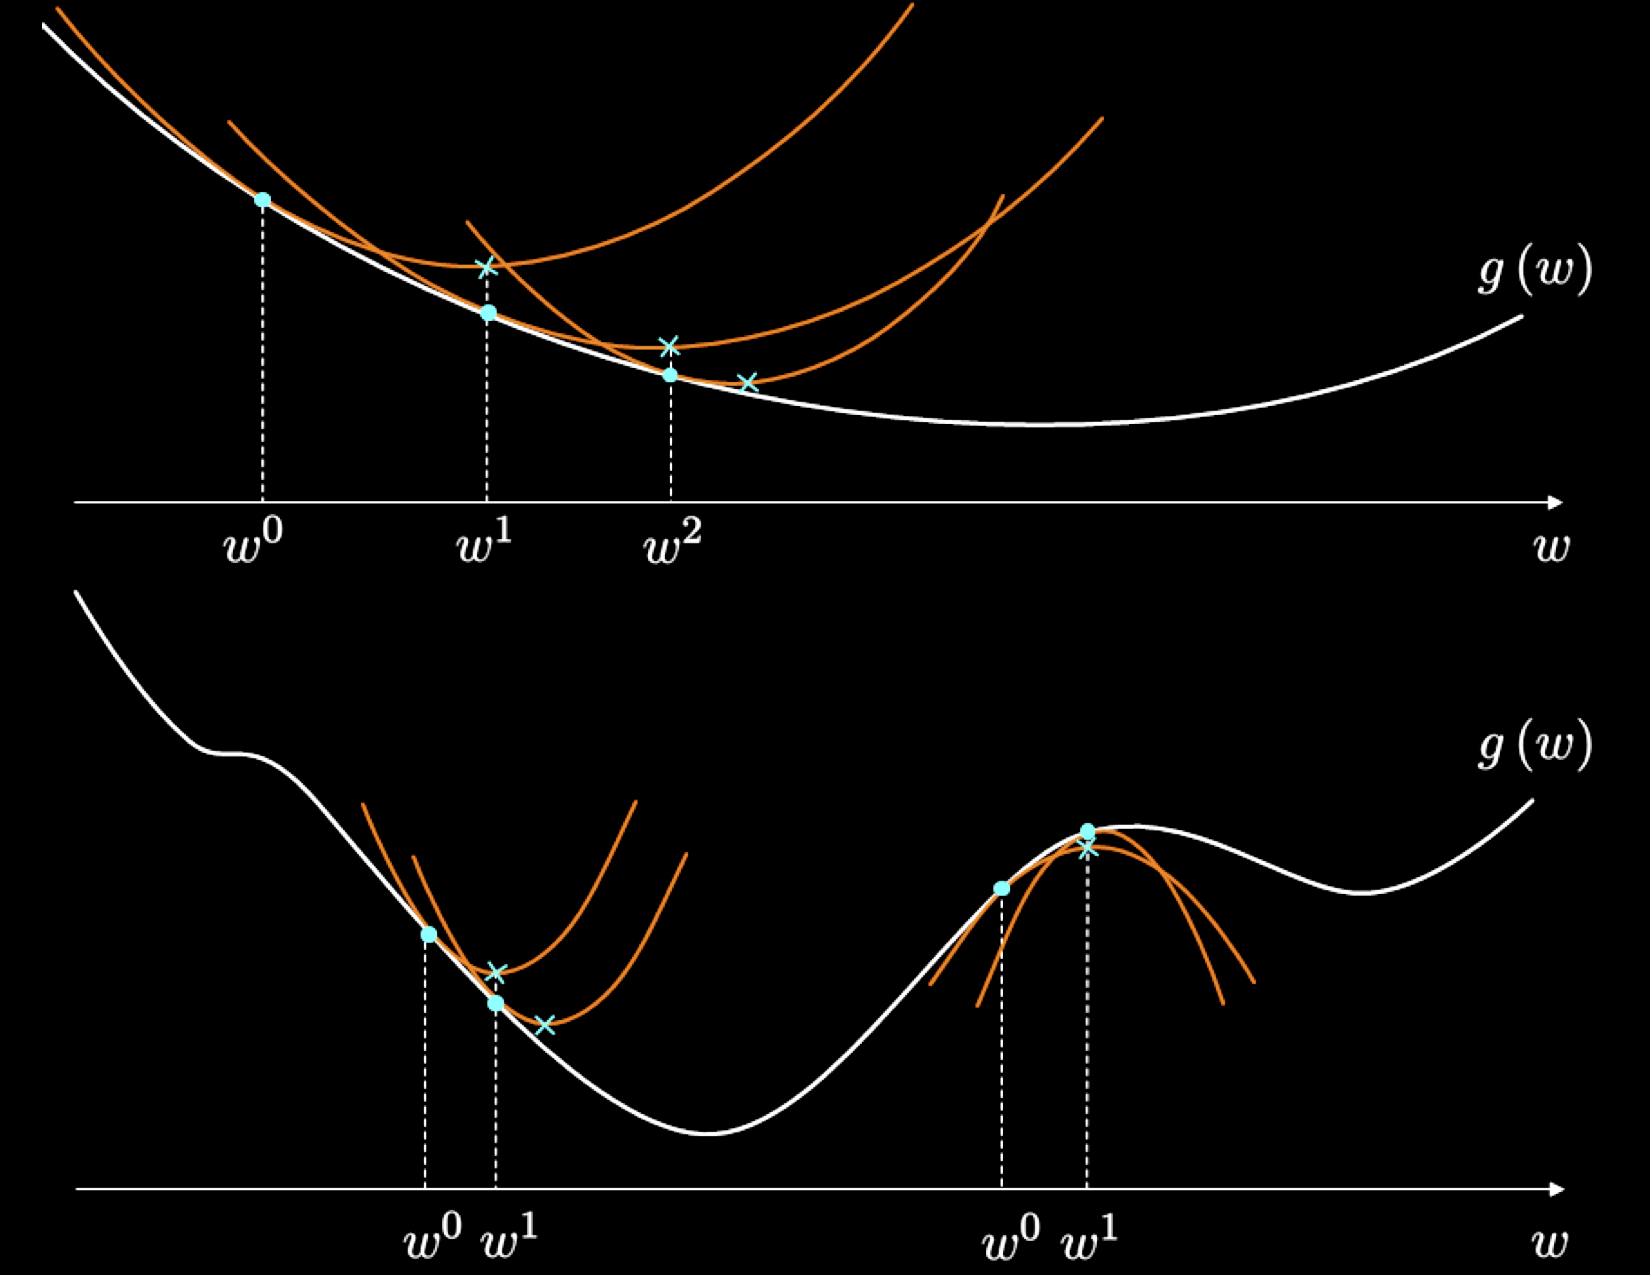

In [91]:
Image("../resources/newton.png", width=800)
# Source: https://jermwatt.github.io/machine_learning_refined/notes/4_Second_order_methods/4_4_Newtons.html

Text(0, 0.5, 'Loss')

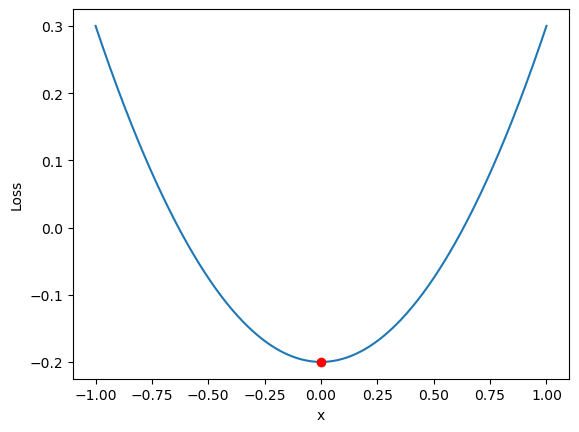

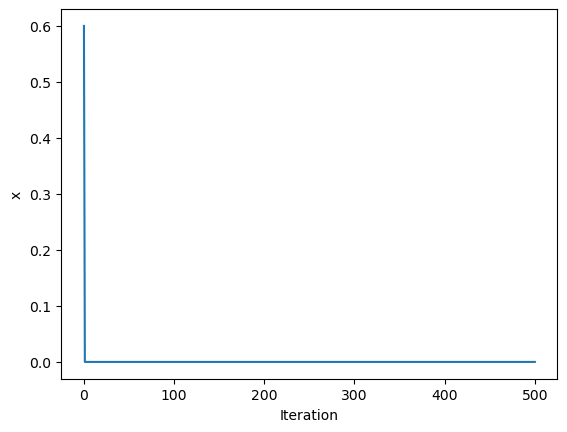

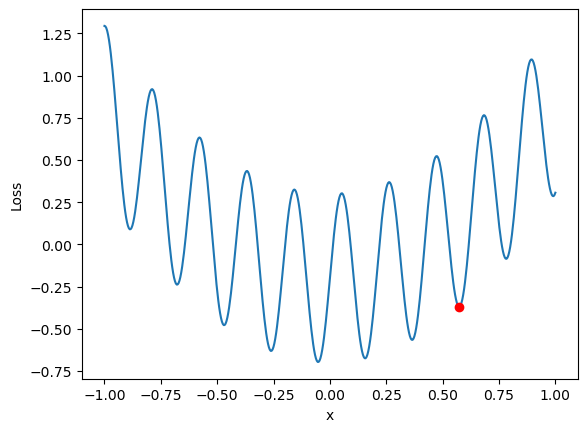

In [136]:
def finite_difference(f, x, dx=1e-5, order=1):
    """
    Compute the derivative of a function using finite differences

    Args:
        f: The function to differentiate
        x: The point at which to differentiate
        dx: The step size
        order: The order of the derivative to compute
    """
    if order == 1:
        return (f(x + dx / 2) - f(x - dx / 2)) / dx
    elif order == 2:
        return (f(x + dx) - 2 * f(x) + f(x - dx)) / dx**2
    else:
        raise ValueError('Only first and second order derivatives are supported')

class NewtonOptimizer:
    """
    A simple implementation of Newton's method for finding the optima of a function

    Parameters:
        tolerance (float): The tolerance for the stopping criterion
        max_iterations (int): The maximum number of iterations to perform
        store_history (bool): Whether to store the history of the optimization
    """
    def __init__(self, tolerance=1e-6, max_iterations=1000, store_history=False):
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.store_history = store_history
        if store_history:
            self.history = list()

    def optimize(self, f, x0, df=None, max_iter=500):

        x = x0

        if self.store_history:  self.history.append(np.copy(x))
        for _ in range(max_iter):

            # Approximate the derivatives
            fd = finite_difference(f, x, order = 1)
            fdd = finite_difference(f, x, order = 2)
            
            ## Stop early if the local concavity is zero
            if np.abs(fdd) < self.tolerance:
                break
            x = x - fd / fdd

            if self.store_history: self.history.append(np.copy(x))
        return x


## Convex function
loss = lambda x: 0.5 * x**2 - 0.2
optimizer = NewtonOptimizer(store_history=True)
xstar = optimizer.optimize(loss, 0.6)

plt.figure()
plt.plot(xx, loss(xx))
plt.plot(xstar, loss(xstar), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

## Non-convex function
loss = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2
optimizer = NewtonOptimizer(store_history=True)
xstar = optimizer.optimize(loss, 0.6)

plt.figure()
plt.plot(xx, loss(xx))
plt.plot(xstar, loss(xstar), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

#### Interpreting the Newton optimizer

We can think of the Newton optimizer as a *second order method*. The update rule for $x$ was

$$
x \leftarrow x - {\frac{f'}{f''}}.
$$

The numerator of the update is just the local gradient step: we take a step in the direction of descent, at a rate proportional to the slope along that direction. The denominator we can interpret as an "adaptive learning rate": we take larger steps as the local landscape gets flatter, and smaller steps in very convex areas.

# Gradient descent in higher dimensions

# Newton's method in higher dimensions


